Epoch [1/200], Loss: 0.9723
Epoch [2/200], Loss: 0.8129
Epoch [3/200], Loss: 0.8006
Epoch [4/200], Loss: 0.7945
Epoch [5/200], Loss: 0.7882
Epoch [6/200], Loss: 0.7767
Epoch [7/200], Loss: 0.7709
Epoch [8/200], Loss: 0.7680
Epoch [9/200], Loss: 0.7663
Epoch [10/200], Loss: 0.7650
Epoch [11/200], Loss: 0.7641
Epoch [12/200], Loss: 0.7632
Epoch [13/200], Loss: 0.7625
Epoch [14/200], Loss: 0.7620
Epoch [15/200], Loss: 0.7615
Epoch [16/200], Loss: 0.7610
Epoch [17/200], Loss: 0.7606
Epoch [18/200], Loss: 0.7604
Epoch [19/200], Loss: 0.7599
Epoch [20/200], Loss: 0.7597
Epoch [21/200], Loss: 0.7595
Epoch [22/200], Loss: 0.7591
Epoch [23/200], Loss: 0.7588
Epoch [24/200], Loss: 0.7586
Epoch [25/200], Loss: 0.7585
Epoch [26/200], Loss: 0.7583
Epoch [27/200], Loss: 0.7582
Epoch [28/200], Loss: 0.7580
Epoch [29/200], Loss: 0.7577
Epoch [30/200], Loss: 0.7576
Epoch [31/200], Loss: 0.7575
Epoch [32/200], Loss: 0.7574
Epoch [33/200], Loss: 0.7573
Epoch [34/200], Loss: 0.7573
Epoch [35/200], Loss: 0

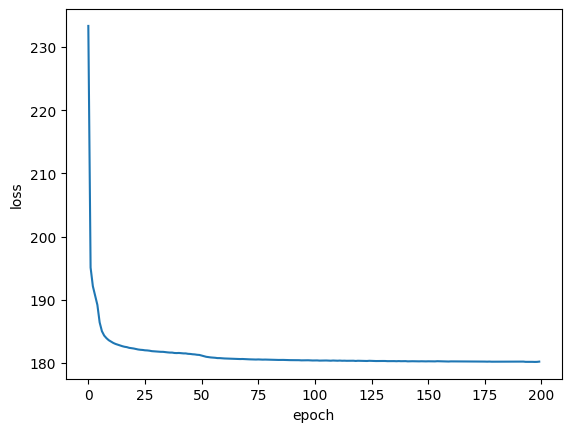

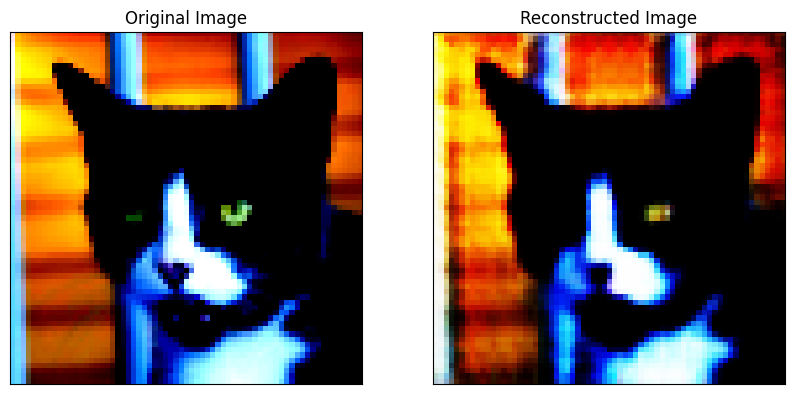

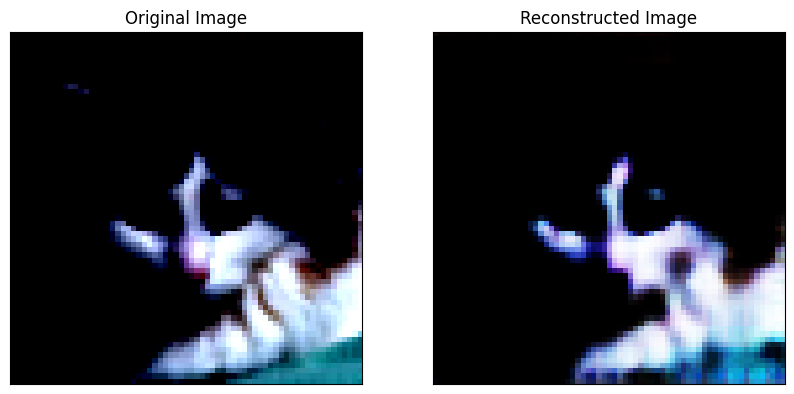

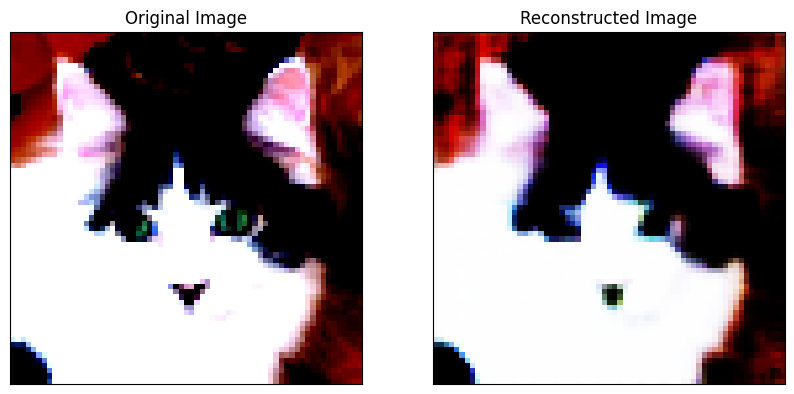

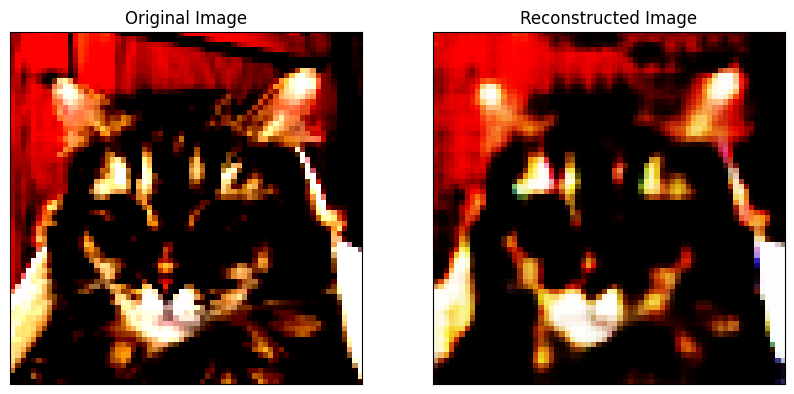

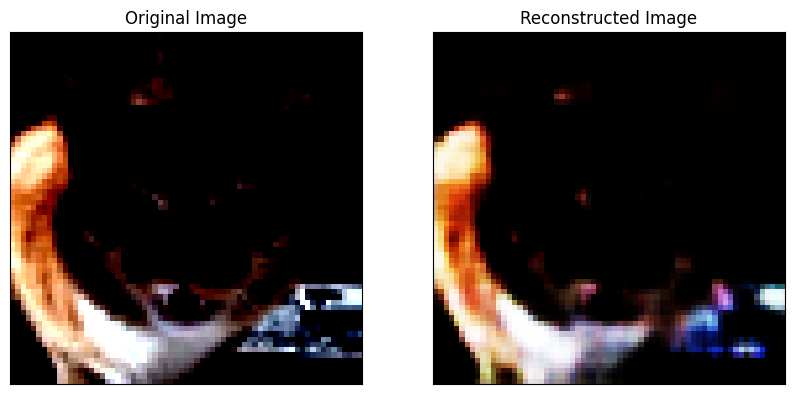

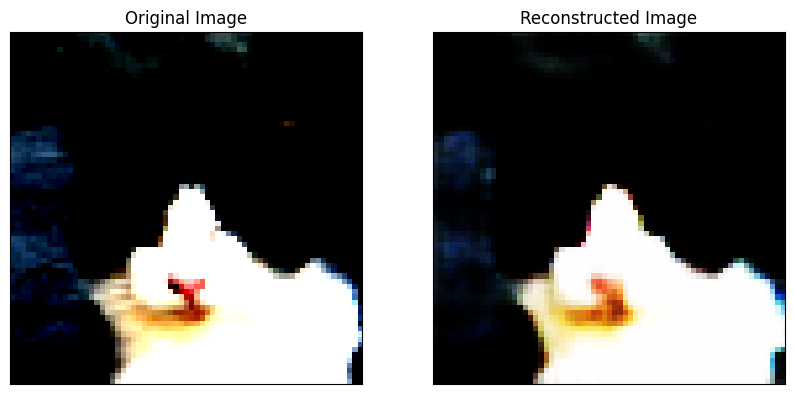

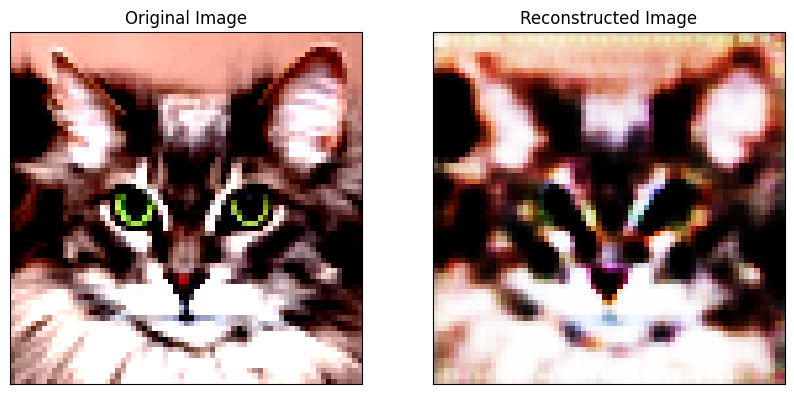

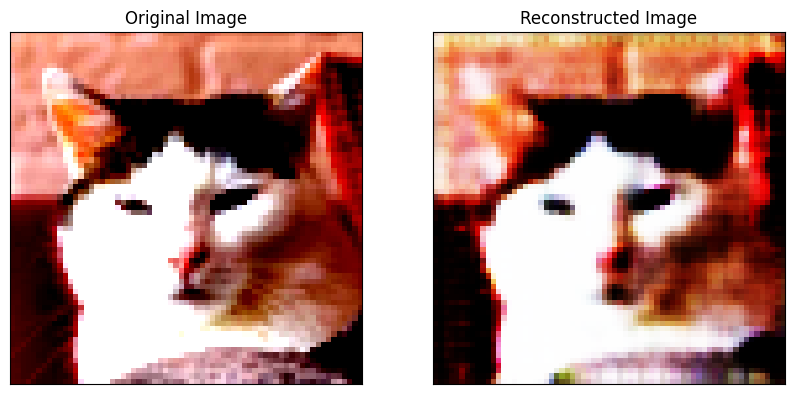

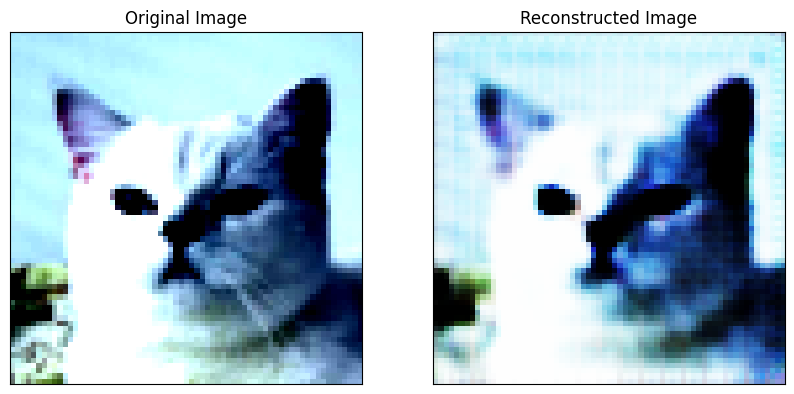

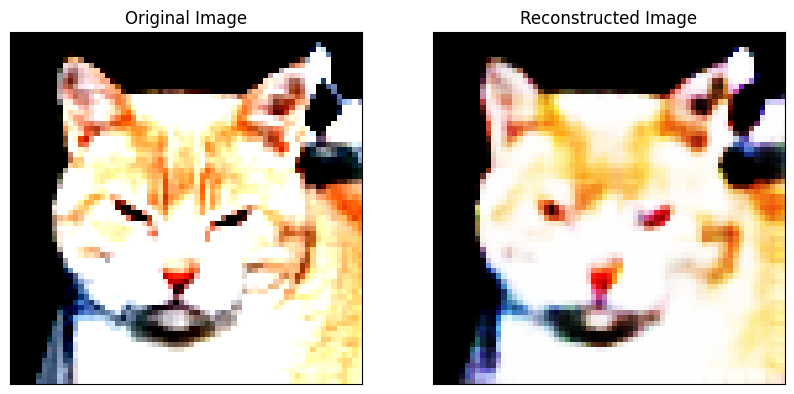

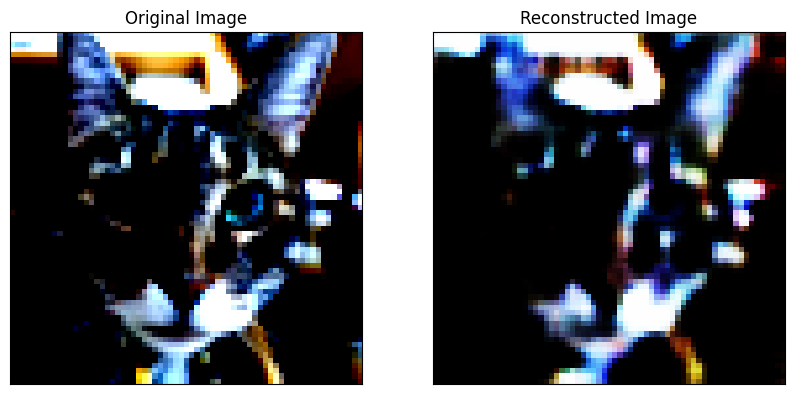

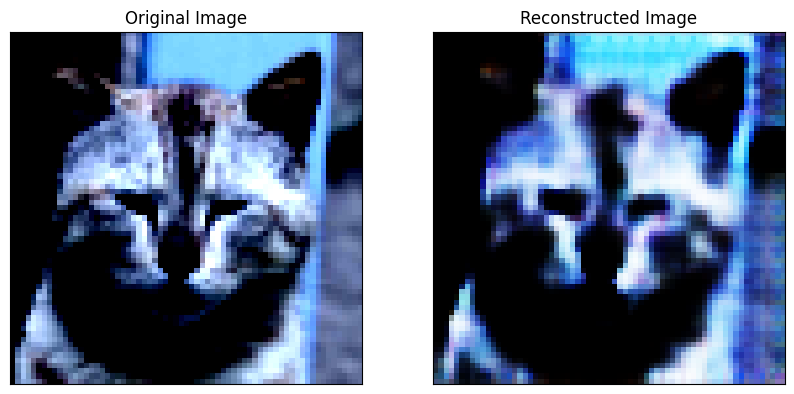

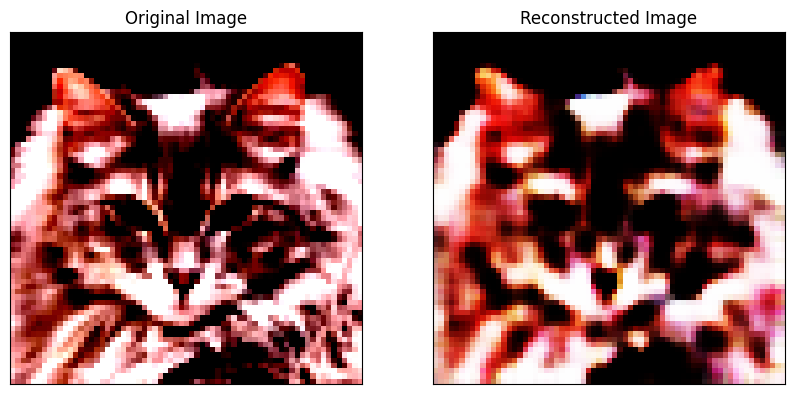

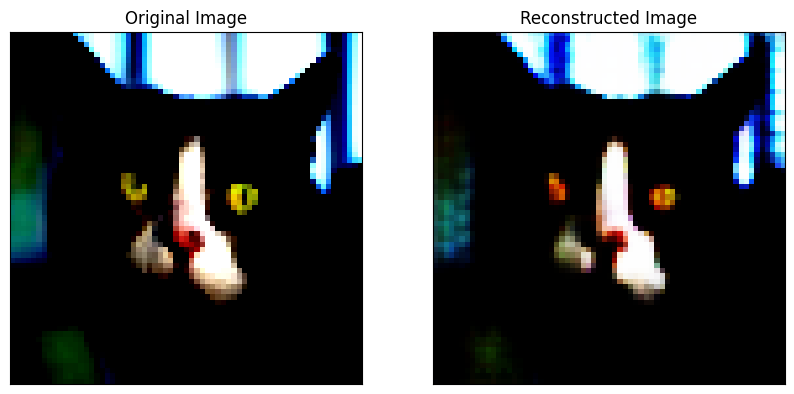

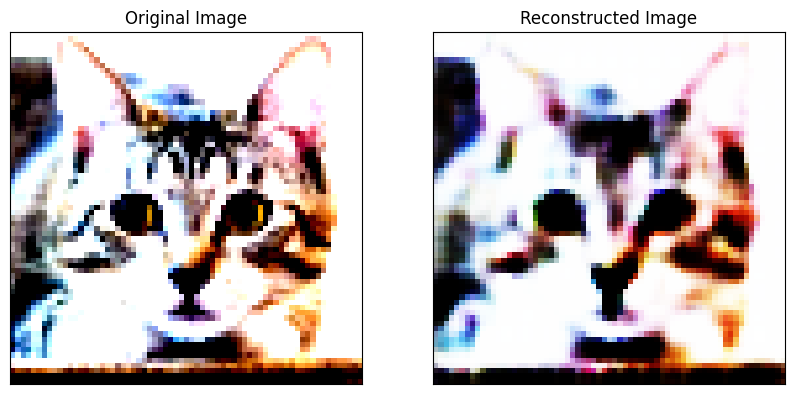

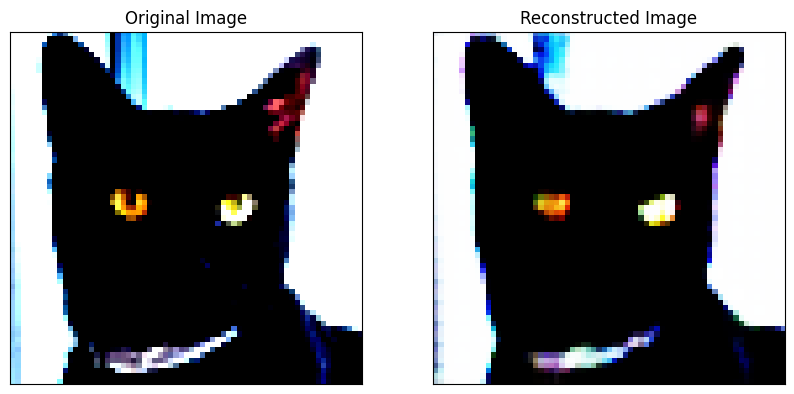

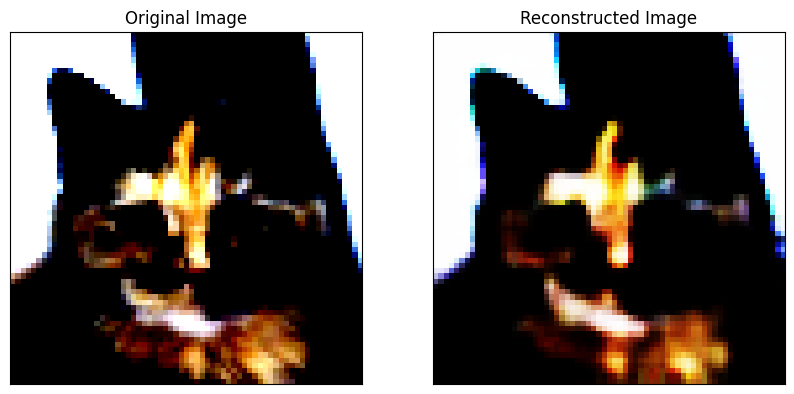

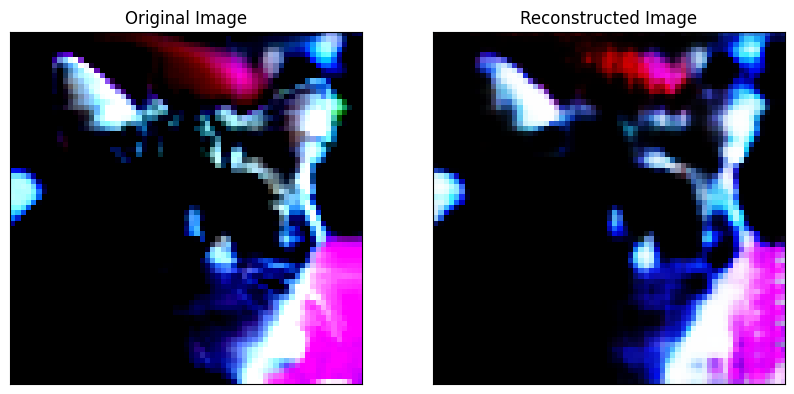

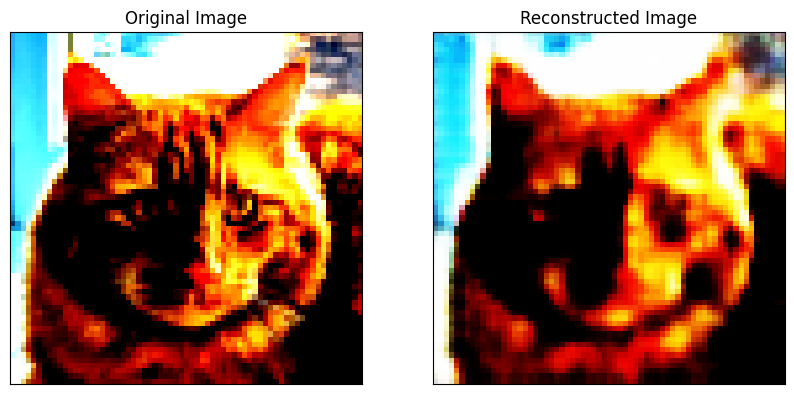

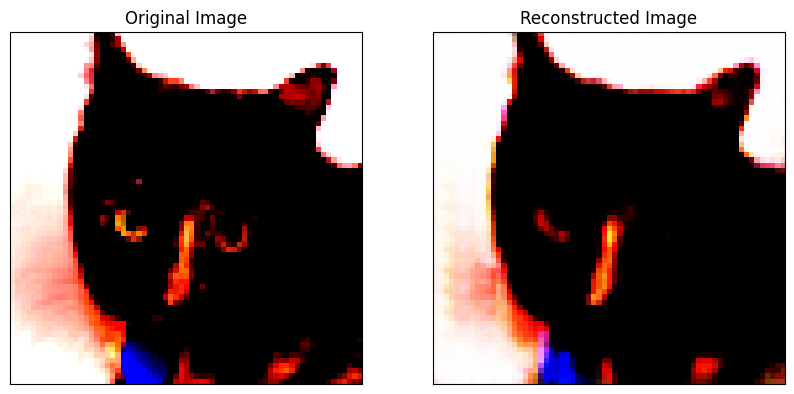

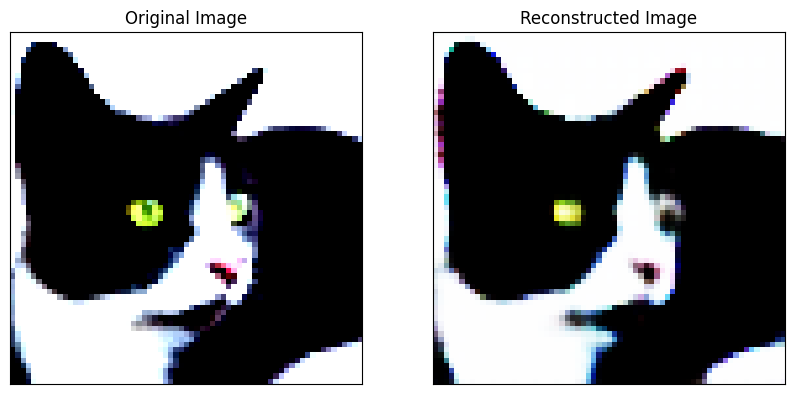

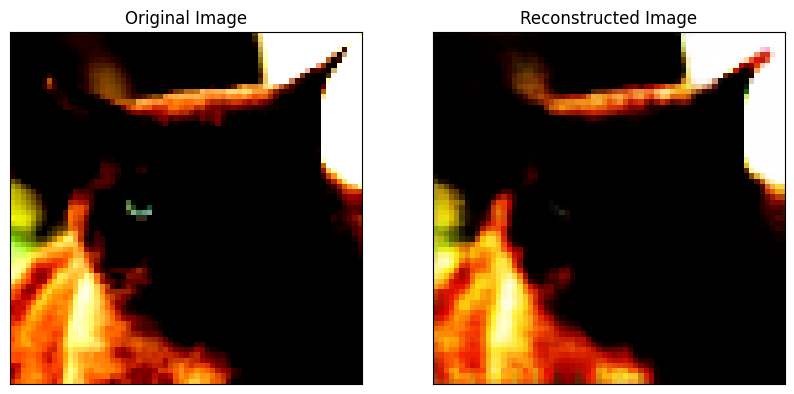

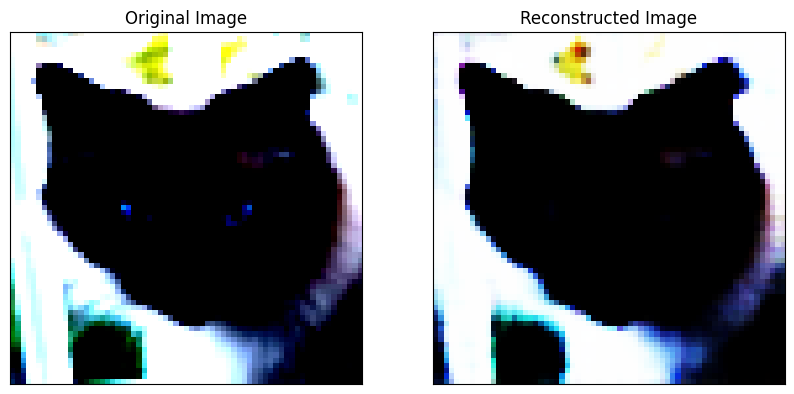

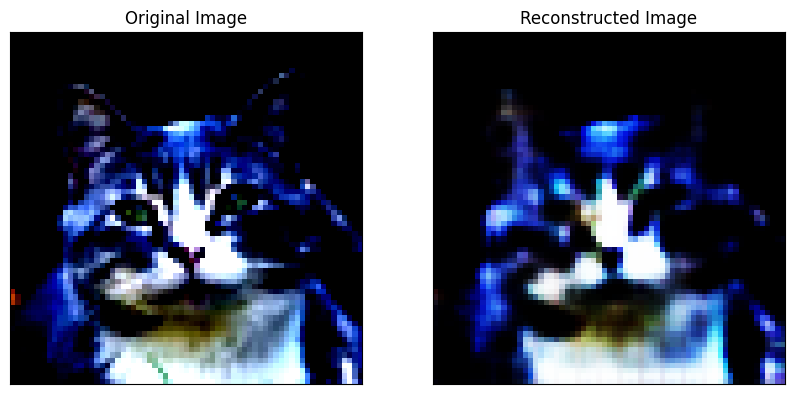

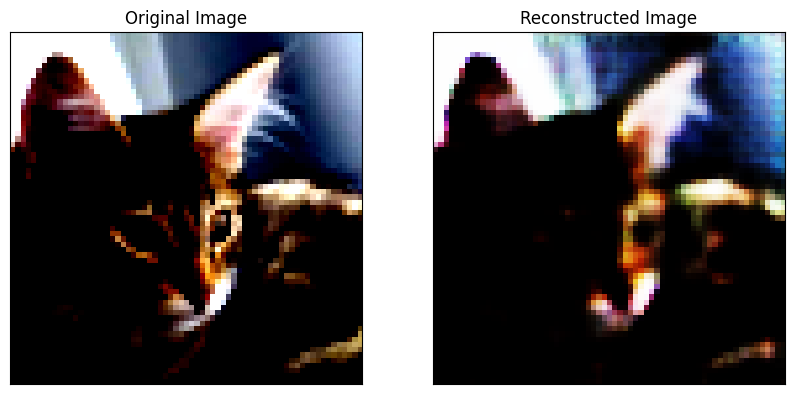

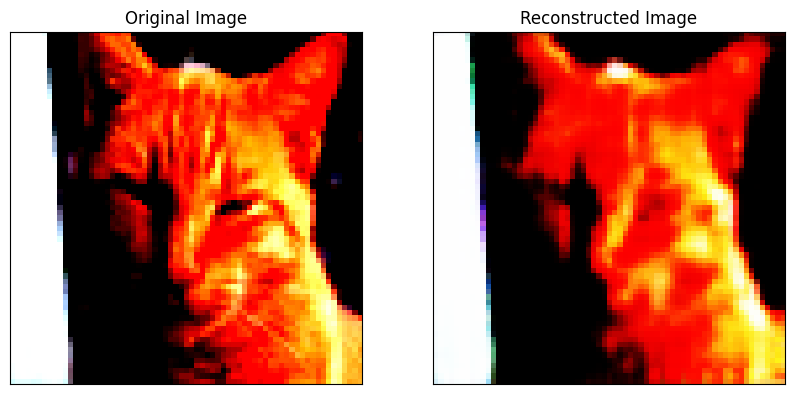

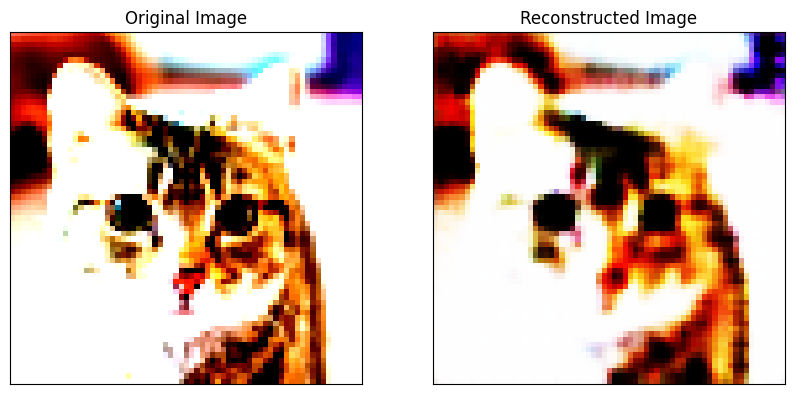

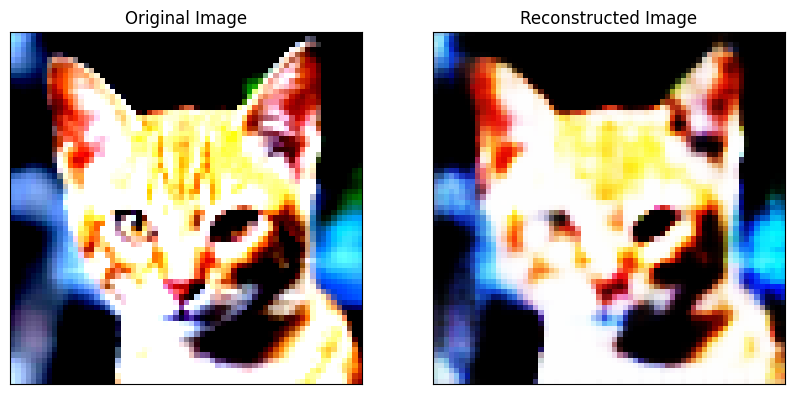

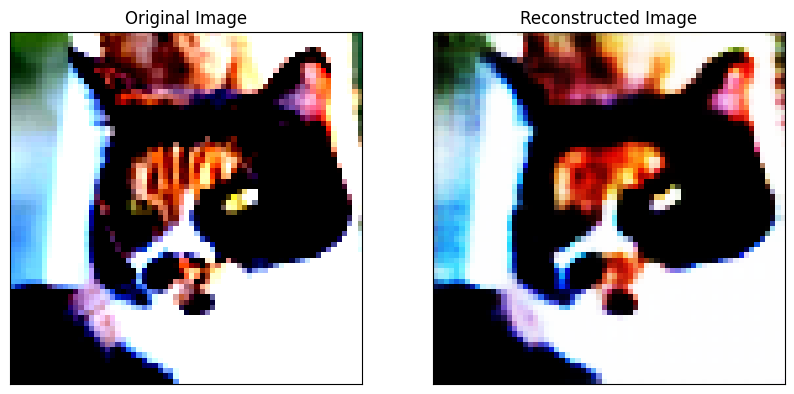

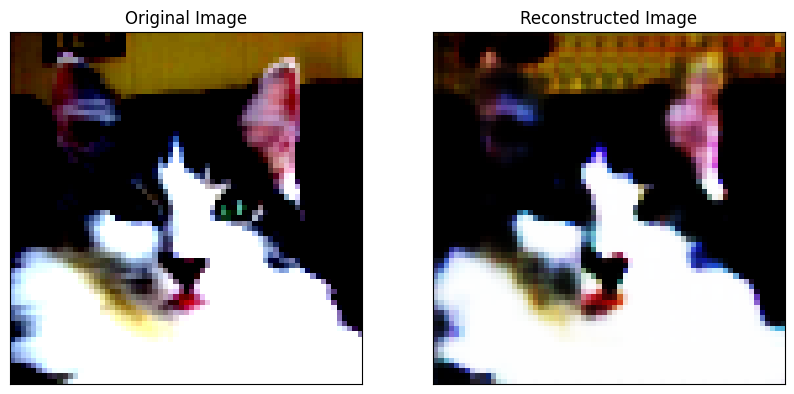

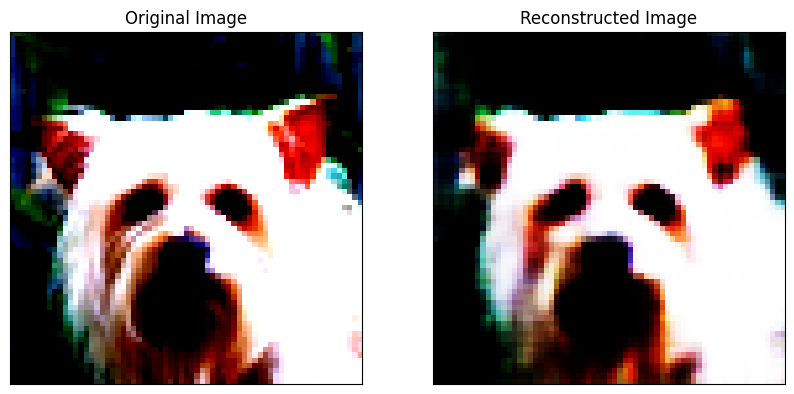

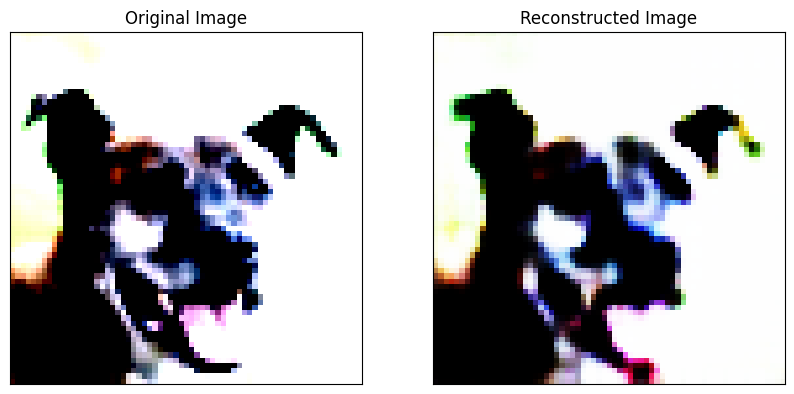

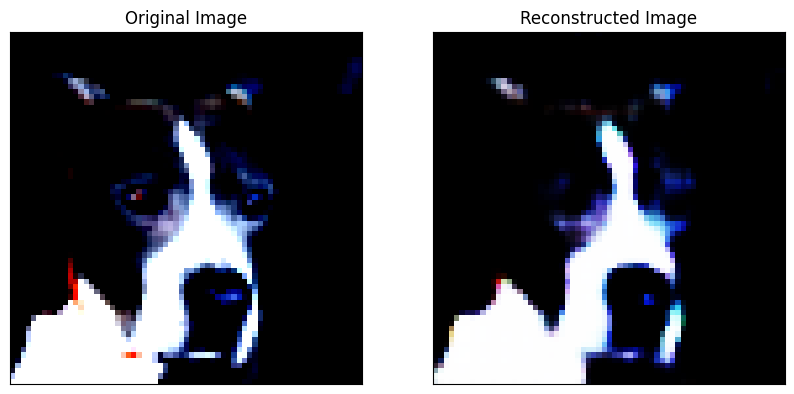

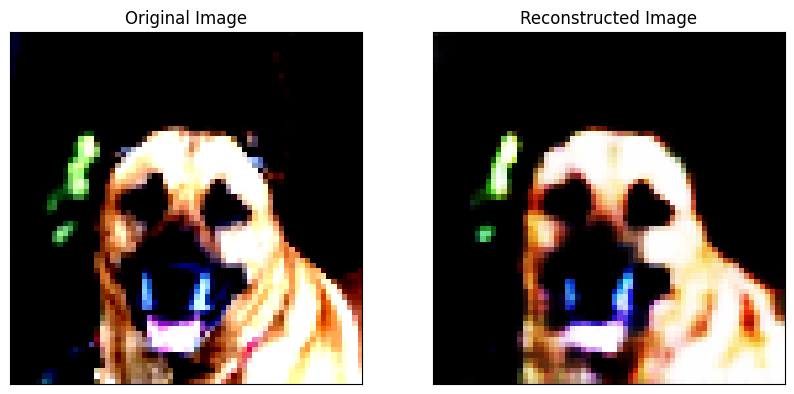

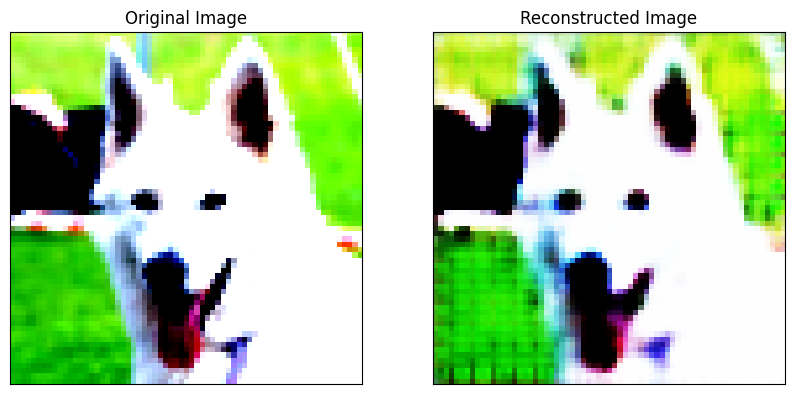

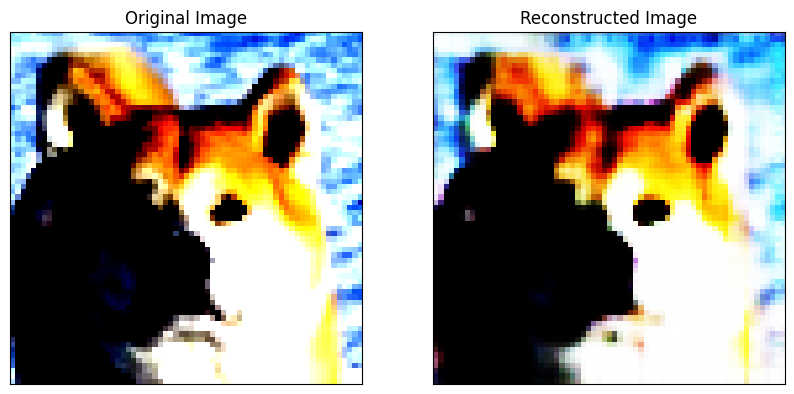

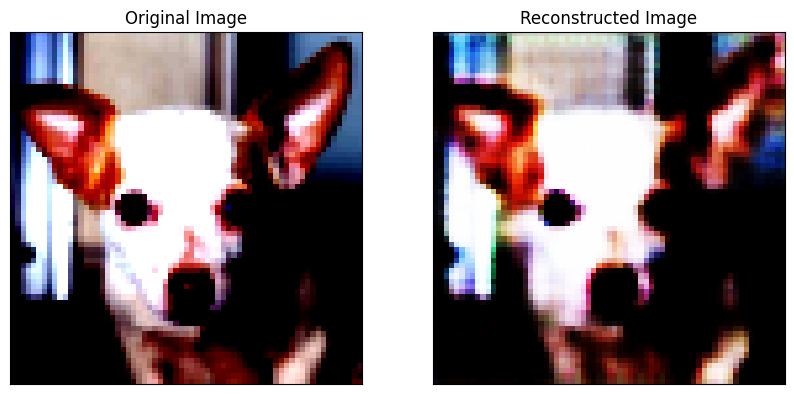

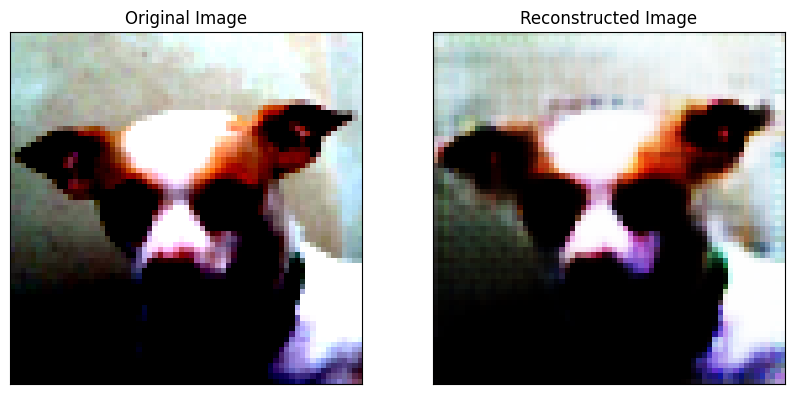

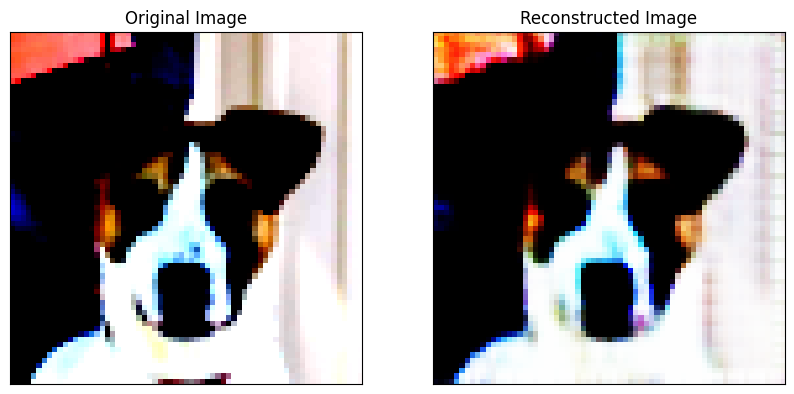

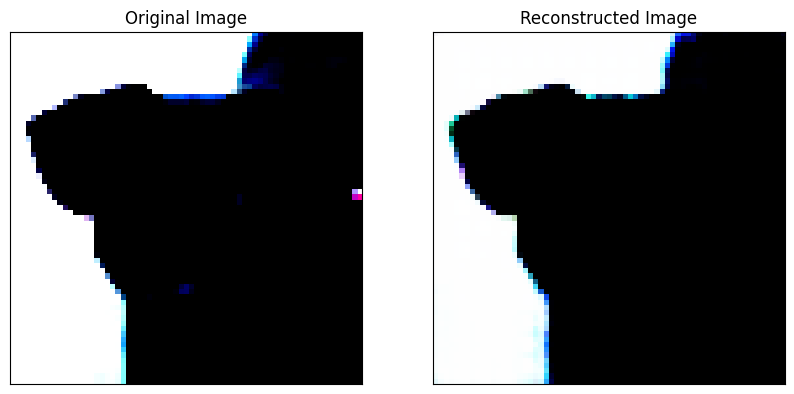

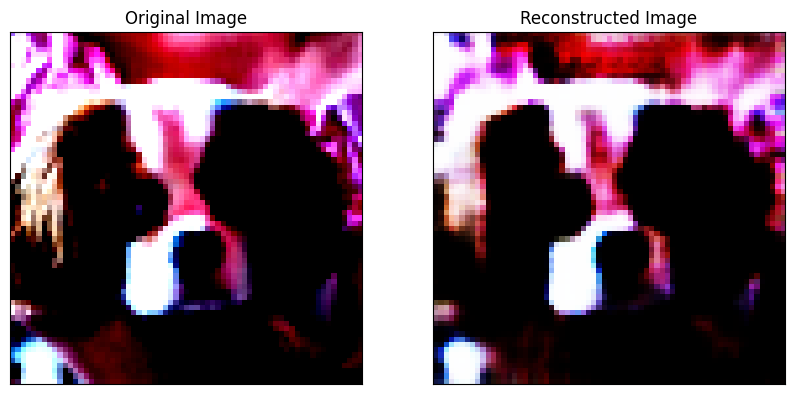

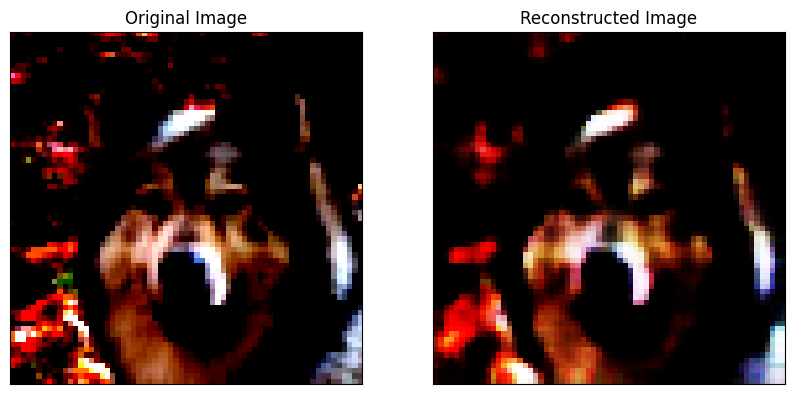

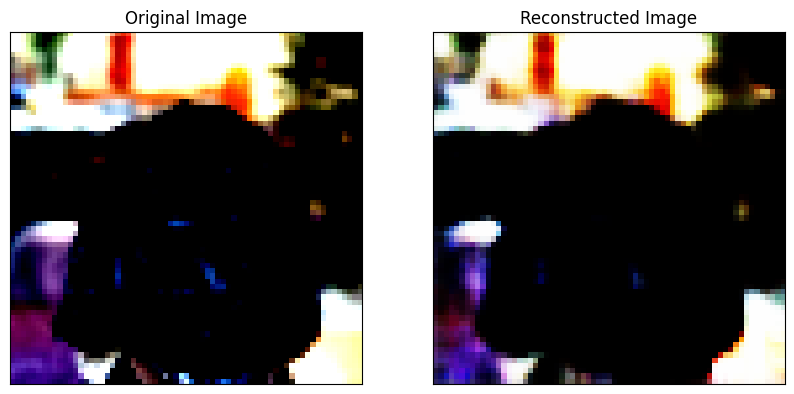

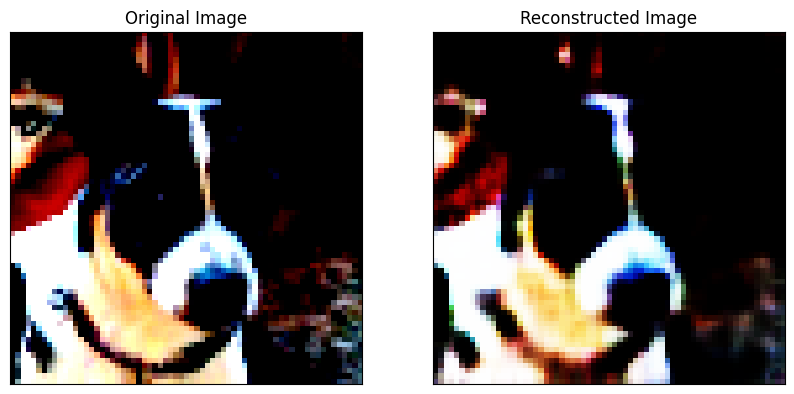

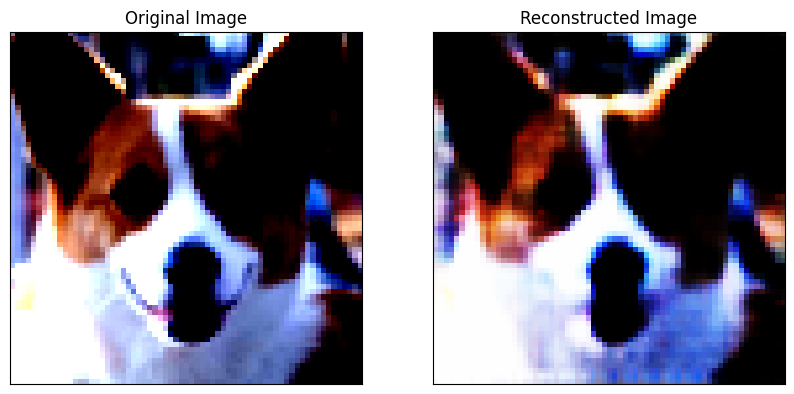

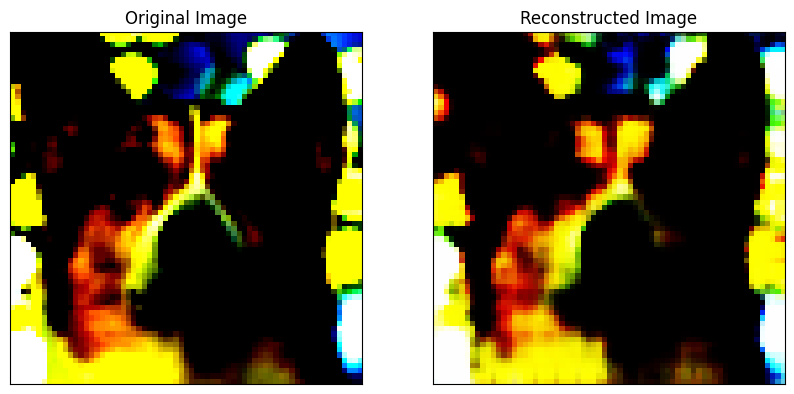

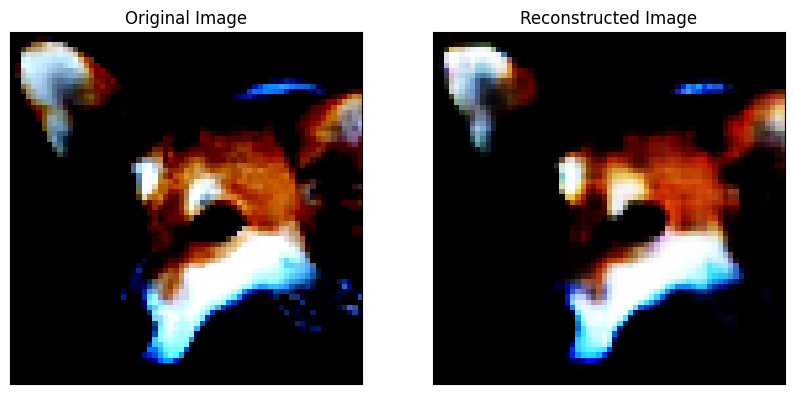

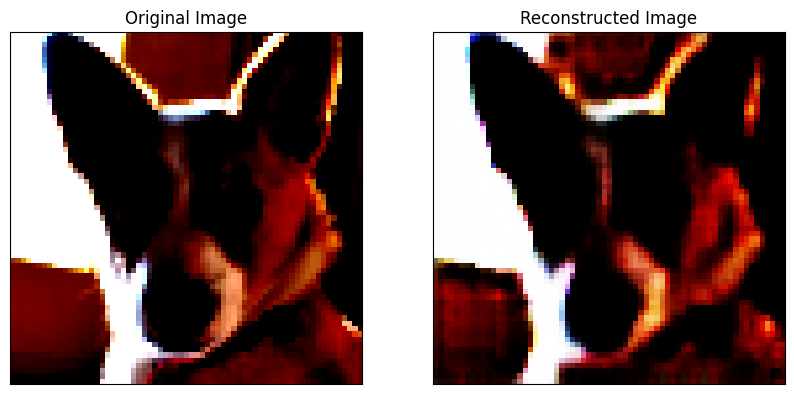

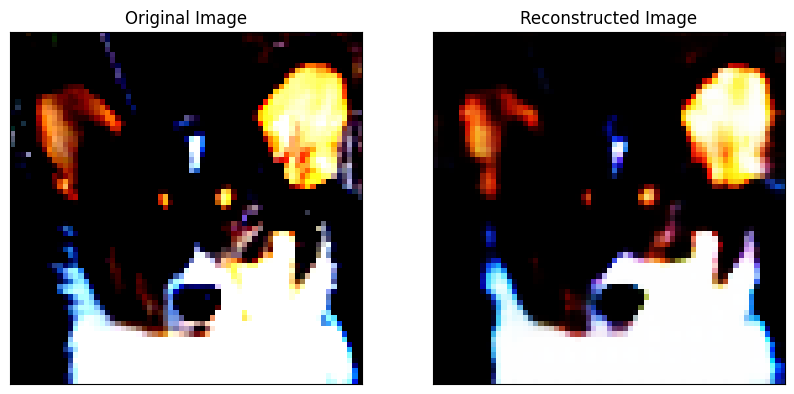

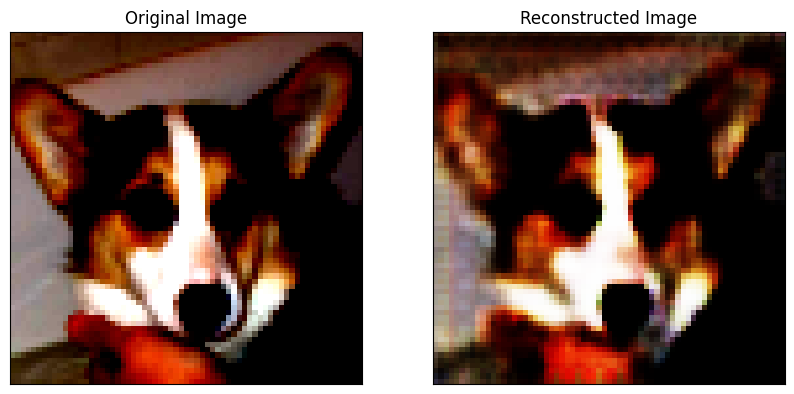

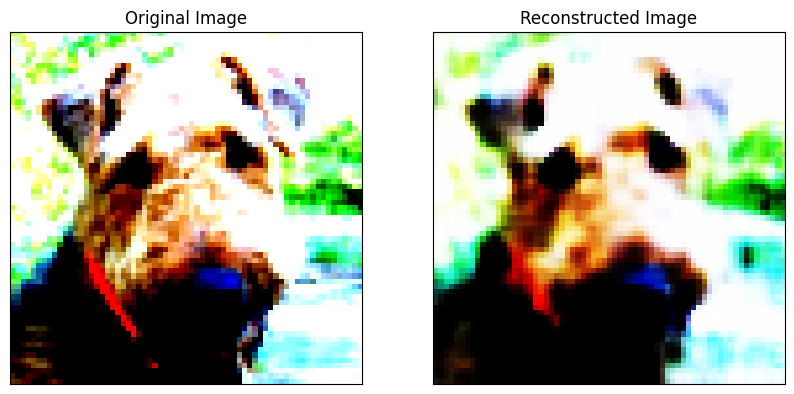

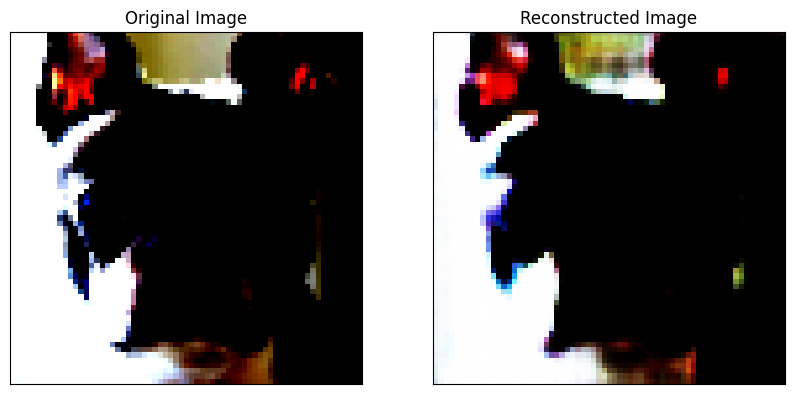

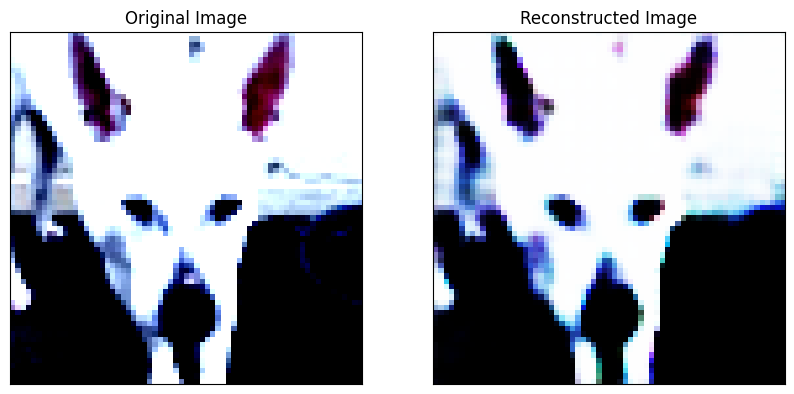

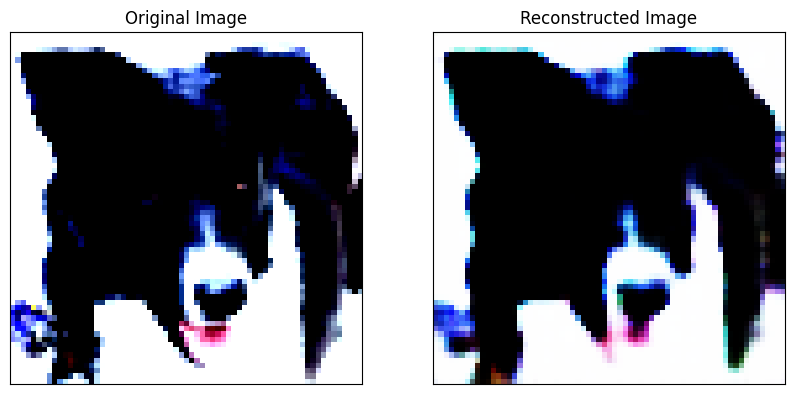

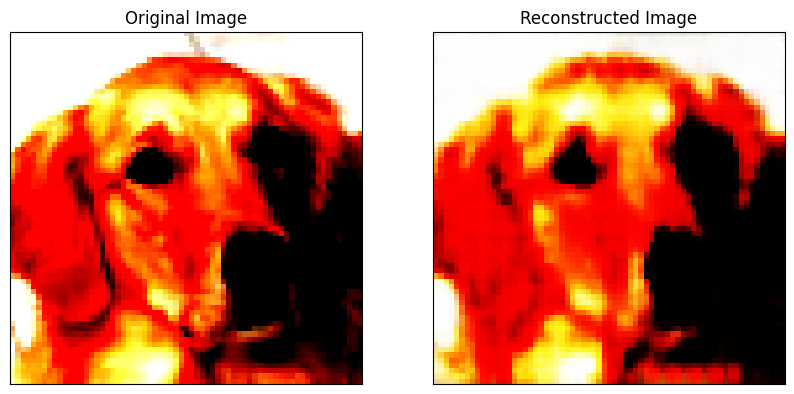

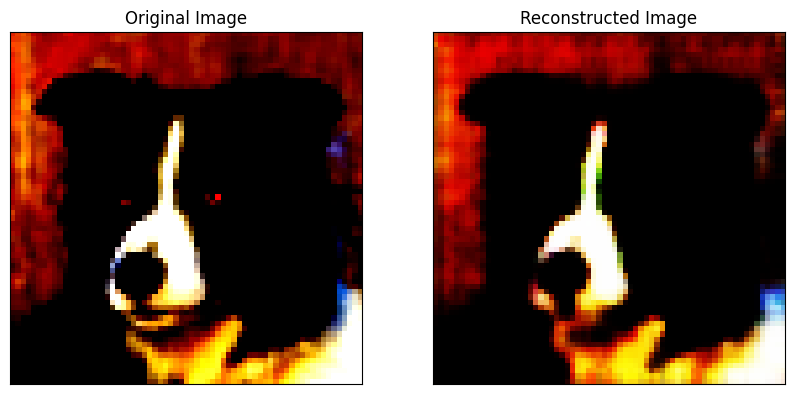

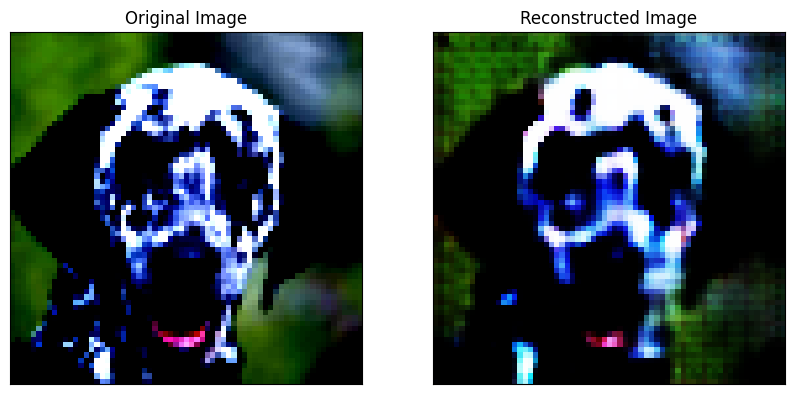

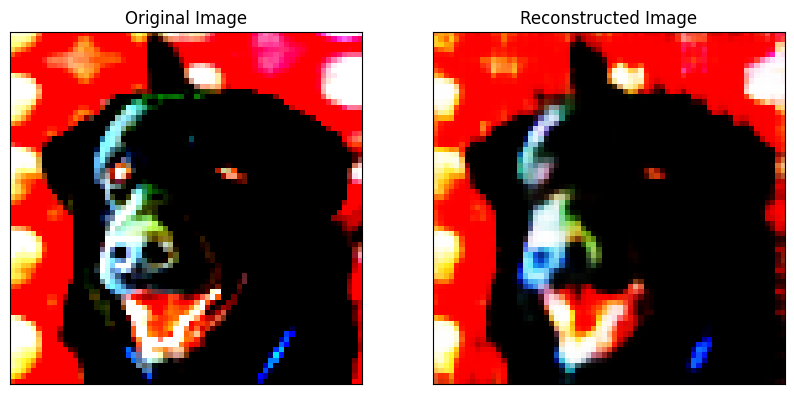

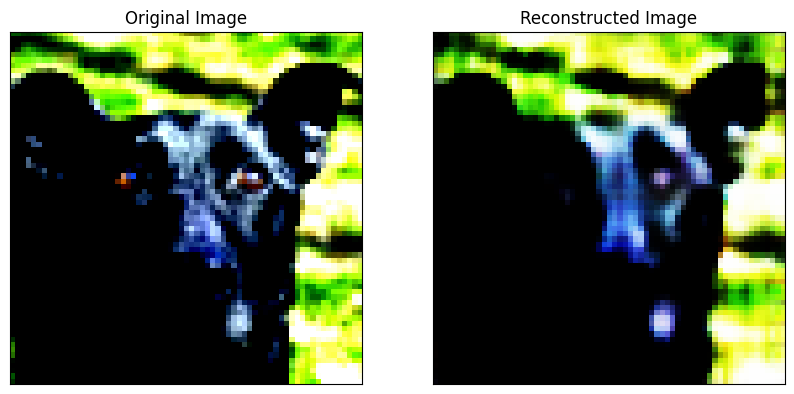

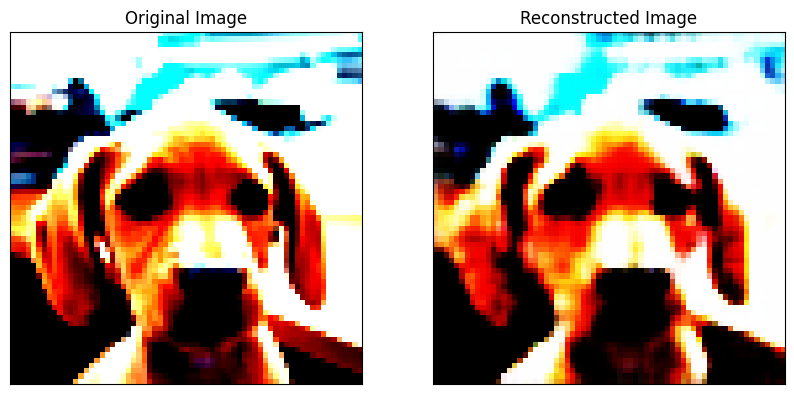

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import os
# # 设置CUDA_LAUNCH_BLOCKING环境变量为1
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# 数据预处理
transform = transforms.Compose([
    transforms.Resize((67, 67)),  # 调整图片大小
    transforms.ToTensor(),  # 转换为Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 归一化
])

# 加载数据集
train_dataset = ImageFolder('/content/drive/MyDrive/深度学习/zibianmaqi/small_data/train', transform=transform)
test_dataset = ImageFolder('/content/drive/MyDrive/深度学习/zibianmaqi/small_data/val', transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 输入3通道图像
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),  # 反卷积操作
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2),  # 输出3通道图像
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# 初始化自编码器
autoencoder = Autoencoder()

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

epochs = 200
all_loss = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, _ = data  # 不需要标签，只使用图像本身
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)  # 输入和输出之间的均方误差
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    all_loss.append(running_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
    running_loss = 0
plt.plot(range(len(all_loss)), all_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
all_loss.clear()


# 获取一批测试数据
dataiter = iter(test_loader)
for i in range(len(test_loader)):
    images, _ = next(dataiter)
    images = images.to(device)

    # 使用训练好的自编码器进行图像重构
    reconstructed = autoencoder(images)

    # 可视化原始图像和重构图像
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # 显示原始图像
    img_original = images[0].cpu().detach().permute(1, 2, 0)
    axes[0].imshow(img_original)
    axes[0].set_title('Original Image')
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)

    # 显示重构图像
    img_reconstructed = reconstructed[0].cpu().detach().permute(1, 2, 0)
    axes[1].imshow(img_reconstructed)
    axes[1].set_title('Reconstructed Image')
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)

    plt.show()